In [1]:
import glob
import msprime
import numpy as np
import tszip
import tskit
import os, gc 
import demes
import demesdraw
import yaml
import pandas as pd
import re #regex
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import sys
from contextlib import redirect_stdout

Functions -- move later to separate file but have to figure out how separate file can inherit conda environ?

In [2]:
#Functions from ChatGPT for turning coal rates into demes yaml
def write_demes_from_ymean(ymean, outfile, deme_name="collapsed_pop"):
    """
    Write a Demes YAML file with piecewise-constant Ne(t).

    ymean columns:
      gen      : time before present (years), increasing into the past
      ne_mean : effective population size
    """

    # Sort youngest → oldest
    y = ymean.sort_values("gen").reset_index(drop=True)

    # Build epochs from OLDEST → YOUNGEST
    epochs = []

    for i in range(len(y) - 1, -1, -1):
        end_time = float(y.loc[i, "gen"])
        epochs.append({
            "end_time": end_time,
            "start_size": float(y.loc[i, "ne_mean"]),
            "end_size": float(y.loc[i, "ne_mean"]),
        })

    # Force the youngest epoch to end at 0 (present)
    epochs[-1]["end_time"] = 0.0

    # Sanity check: end_times strictly decreasing
    ends = [e["end_time"] for e in epochs]
    assert all(ends[i] > ends[i+1] for i in range(len(ends) - 1)), ends

    graph = {
        "time_units": "years",
        "generation_time": 1,
        "demes": [
            {
                "name": deme_name,
                "epochs": epochs,
            }
        ],
    }

    with open(outfile, "w") as f:
        yaml.safe_dump(graph, f, sort_keys=False)

#Functions from chatGPT for plotting π on original coordinates after collpasing
def inverse_cum_mass_map(mask, L, step=1000):
    """
    Build an approximate inverse map from new (collapsed) coordinate -> old coordinate,
    by sampling old positions and their cumulative mass.

    step: spacing (bp) in ORIGINAL coords for the lookup grid; smaller = more accurate.
    """
    old = np.arange(0, L + step, step, dtype=float)
    if old[-1] > L:
        old[-1] = L

    new = mask.get_cumulative_mass(old)  # monotonically nondecreasing

    # Keep only points where new increases (avoid flat segments from masked regions)
    keep = np.concatenate([[True], np.diff(new) > 0])
    old2 = old[keep]
    new2 = new[keep]

    return new2, old2  # new2 is increasing, so we can interpolate

#Functions from ChatGPT for interval pruning and merging
def merge_intervals(intervals):
    """
    Merge overlapping or adjacent half-open intervals [left, right).
    Returns a Python list of [left, right] intervals sorted by left.
    """
    if len(intervals) == 0:
        return []

    intervals = np.asarray(intervals, dtype=float)
    intervals = intervals[np.argsort(intervals[:, 0])]

    merged = [intervals[0].tolist()]
    for left, right in intervals[1:]:
        # If overlap or adjacency, merge by extending the right endpoint
        if left <= merged[-1][1]:
            merged[-1][1] = max(merged[-1][1], right)
        else:
            merged.append([left, right])

    return merged

def accessible_intervals_from_mu(mu):
    # mu.position are interval boundaries; mu.rate[i] applies on [pos[i], pos[i+1])
    pos = np.asarray(mu.position, dtype=float)
    rate = np.asarray(mu.rate)
    keep = rate > 0
    # intervals where keep==True
    lefts = pos[:-1][keep]
    rights = pos[1:][keep]
    return np.column_stack([lefts, rights])

def overlap_lengths(intervals, windows):
    """
    intervals: (m,2) array of [left,right)
    windows: (k+1,) edges
    returns: (k,) total interval overlap length per window
    """
    intervals = np.asarray(intervals, dtype=float)
    windows = np.asarray(windows, dtype=float)
    k = len(windows) - 1
    out = np.zeros(k, dtype=float)

    # sweep pointers through sorted intervals and windows
    i = 0
    m = len(intervals)
    for w in range(k):
        wl, wr = windows[w], windows[w+1]
        # advance intervals that end before this window
        while i < m and intervals[i, 1] <= wl:
            i += 1
        j = i
        # accumulate overlaps for intervals that might intersect this window
        while j < m and intervals[j, 0] < wr:
            ol = max(wl, intervals[j, 0])
            or_ = min(wr, intervals[j, 1])
            if or_ > ol:
                out[w] += (or_ - ol)
            if intervals[j, 1] >= wr:
                break
            j += 1
    return out
    
def ratemap_from_keep_intervals(keep_intervals, L):
    """
    Build a binary RateMap (0/1) over [0, L] with rate=1 in keep_intervals.
    """
    keep = sorted([[max(0.0, float(l)), min(float(L), float(r))]
                   for l, r in keep_intervals if r > l],
                  key=lambda x: x[0])

    # Collect all breakpoints
    breaks = [0.0]
    for l, r in keep:
        breaks.extend([l, r])
    breaks.append(float(L))

    pos = np.unique(np.asarray(breaks, dtype=float))
    pos.sort()

    rate = np.zeros(len(pos) - 1, dtype=float)

    k = 0
    for i in range(len(rate)):
        seg_l, seg_r = pos[i], pos[i + 1]
        while k < len(keep) and keep[k][1] <= seg_l:
            k += 1
        if k < len(keep) and keep[k][0] < seg_r and keep[k][1] > seg_l:
            rate[i] = 1.0

    return msprime.RateMap(position=pos, rate=rate)


def and_ratemaps_binary(a: msprime.RateMap, b: msprime.RateMap):
    """
    Return a binary RateMap that is 1 where BOTH a and b are 1, else 0.

    Assumes both are binary (0/1) and share the same sequence_length.
    """
    assert a.sequence_length == b.sequence_length

    # Union of breakpoints from both maps
    pos = np.unique(np.concatenate([np.asarray(a.position), np.asarray(b.position)]))
    pos.sort()

    # Rates for each segment in the union-partition
    ra = a.get_rate(pos[:-1])
    rb = b.get_rate(pos[:-1])

    rate = (ra.astype(bool) & rb.astype(bool)).astype(float)

    return msprime.RateMap(position=pos, rate=rate)

def drop_individual_by_name_fast(ts, target_name, suffix_to_strip="_anchorwave"):
    # Find the individual id
    ind_to_drop = None
    for ind_id, ind in enumerate(ts.individuals()):
        nm = ind.metadata["id"].replace(suffix_to_strip, "")
        if nm == target_name:
            ind_to_drop = ind_id
            break
    if ind_to_drop is None:
        raise ValueError(f"{target_name} not found")

    drop_nodes = set(ts.individual(ind_to_drop).nodes)

    # Build keep list using node IDs (not indices)
    keep = [u for u in ts.samples() if u not in drop_nodes]

    # Simplify returns a NEW TS
    return ts.simplify(samples=keep, keep_unary=True)

def collapse_masked_and_low_access_windows(
    ts,
    mu,
    window_size,
    cutoff_bp,
):
    """
    Combine:
      1) the base mask from mu (mu.rate > 0)
      2) the 'good windows' mask (windows with >= cutoff_bp accessible bp)
    into ONE RateMap, then run collapse_masked_intervals(ts, mask).

    Returns
    -------
    ts2 : collapsed TreeSequence (coordinates compacted; sequence_length shrinks)
    mask : msprime.RateMap (binary 0/1) actually used for collapsing
    good_intervals : kept windows merged (original coords)
    windows : window edges (original coords)
    acc_bp : accessible bp per window (original coords)
    """
    L = float(ts.sequence_length)

    # ---- 1) Base accessibility from mu (your existing approach) ----
    # This is binary: 1 where mu.rate > 0, else 0
    acc_mu = msprime.RateMap(position=np.asarray(mu.position, dtype=float),
                             rate=(np.asarray(mu.rate) > 0).astype(float))
    assert acc_mu.sequence_length == L

    # ---- 2) Compute accessible bp per window from mu-derived intervals ----
    # This uses your helper to convert mu into explicit accessible intervals.
    acc_intervals = accessible_intervals_from_mu(mu)

    windows = np.arange(0, L + window_size, window_size, dtype=float)
    if windows[-1] > L:
        windows[-1] = L

    acc_bp = overlap_lengths(acc_intervals, windows)
    assert len(acc_bp) == len(windows) - 1, (
        f"acc_bp has length {len(acc_bp)} but expected {len(windows) - 1}"
    )
    # acc_bp must be between 0 and window_size (except possibly last window)
    assert np.all(acc_bp >= 0)
    assert np.all(acc_bp[:-1] <= window_size + 1e-6)

    # Build merged "good window" intervals: windows with enough accessible bp
    good = []
    for i in range(len(windows) - 1):
        if acc_bp[i] >= cutoff_bp:
            good.append([windows[i], windows[i + 1]])
    good_intervals = merge_intervals(good)

    if len(good_intervals) == 0:
        raise ValueError("No windows pass the accessibility cutoff; nothing to keep.")

    # Turn good intervals into a binary RateMap
    acc_win = ratemap_from_keep_intervals(good_intervals, L)

    # ---- 3) Combine both masks: keep only where BOTH are accessible ----
    mask = and_ratemaps_binary(acc_mu, acc_win)

    # ---- 4) Collapse masked sequence in ONE step (compacts coordinates) ----
    ts2 = collapse_masked_intervals(ts, mask)

    return ts2, mask, good_intervals, windows, acc_bp


#Unit test by JRI -- my first function!!
def unit_pi(ts, mumap):
    weights = ts.pair_coalescence_counts()
    print( "branch π:", 2 * np.sum(ts.nodes_time * weights) / weights.sum(), 
    "site π:", ts.diversity(mode="site")/mutation_rate)

#Functions from Nate
def mutational_load(ts: tskit.TreeSequence, windows: np.ndarray = None) -> np.ndarray:
    """
    Calculate the number of derived mutations per sample.
    """
    genome_windows = np.array([0, ts.sequence_length]) if windows is None else windows
    assert genome_windows[0] == 0 and genome_windows[-1] == ts.sequence_length
    mutations_window = np.digitize(ts.sites_position[ts.mutations_site], genome_windows) - 1
    assert mutations_window.min() >= 0 and mutations_window.max() < genome_windows.size - 1
    load = np.zeros((genome_windows.size - 1, ts.num_samples))
    tree = ts.first(sample_lists=True)
    for s in ts.sites():
        tree.seek(s.position)
        for m in s.mutations:
            if m.edge != tskit.NULL:
                window = mutations_window[m.id]
                samples = list(tree.samples(m.node))
                load[window, samples] += 1.0
    return load.squeeze(0) if windows is None else load
    
def collapse_masked_intervals(
    ts: tskit.TreeSequence, 
    accessible: msprime.RateMap,
) -> tskit.TreeSequence:
    """
    Return a copy of the tree sequence with masked intervals (where `accessible.rate == 0.0`)
    collapsed, so that the coordinate system is in terms of unmasked sequence length.
    Zero length edges are removed, and any nodes that are then disconnected are removed as well.
    All sites and mutations that are within the collapsed intervals are removed.
    """
    assert np.all(np.logical_or(accessible.rate == 0.0, accessible.rate == 1.0))
    assert accessible.sequence_length == ts.sequence_length
    tab = ts.dump_tables()
    tab.sequence_length = accessible.get_cumulative_mass(ts.sequence_length)
    # map edges to new coordinate system and remove those with zero length
    tab.edges.left = accessible.get_cumulative_mass(tab.edges.left)
    tab.edges.right = accessible.get_cumulative_mass(tab.edges.right)
    tab.edges.keep_rows(tab.edges.right > tab.edges.left)
    # remove disconnected nodes
    is_connected = np.full(tab.nodes.num_rows, False)
    is_connected[tab.edges.parent] = True
    is_connected[tab.edges.child] = True
    node_map = tab.nodes.keep_rows(is_connected)
    tab.edges.parent = node_map[tab.edges.parent]
    tab.edges.child = node_map[tab.edges.child]
    # map sites to new coordinate system and remove those in masked intervals
    site_map = tab.sites.keep_rows(accessible.get_rate(tab.sites.position).astype(bool))
    tab.sites.position = accessible.get_cumulative_mass(tab.sites.position)
    # update mutation pointers and remove those without a node or site
    tab.mutations.node = node_map[tab.mutations.node]
    tab.mutations.site = site_map[tab.mutations.site]
    tab.mutations.keep_rows(
        np.logical_and(
            tab.mutations.site != tskit.NULL, 
            tab.mutations.node != tskit.NULL,
        )
    )
    tab.sort()
    tab.build_index()
    tab.compute_mutation_parents()
    return tab.tree_sequence()

def compute_coalescence_rates(ts_list, time_chunks):  # modified to take list of ts rather than files
    """
    Compute coalescence rates for a list of tree sequences.

    Parameters:
    - ts_list (list of ts)

    Returns:
    - pandas.DataFrame with columns: ['tree_num', 'gen', 'rate'] <- use gen as "breaks" causes R issues
    """
    results = []
    tree_num=0

    for ts in ts_list:
        # Calculate rates
        rates = ts.pair_coalescence_rates(time_windows=np.unique(time_chunks))

        # Manage cases where consecutive time breaks were the same
        # This step only matters if you (1) messed up, or (2) are using some quantile-based approach
        if len(rates) != len(time_chunks) - 1:
            unique_elements, counts = np.unique(time_chunks, return_counts=True)
            non_unique_values = unique_elements[counts > 1]
        
            indices_of_non_unique = []
            for val in non_unique_values:
                indices = np.where(time_chunks == val)[0]
                indices_of_non_unique.extend(indices)
        
            # Proceed only if we found duplicates
            if indices_of_non_unique:
                indices_of_non_unique = np.array(sorted(list(set(indices_of_non_unique))))
                double_em = indices_of_non_unique[0]
        
                rep_rate = rates[double_em]
                if double_em != 0:
                    rates = np.insert(rates, double_em, rep_rate)
        
        df = pd.DataFrame({'breaks': np.concatenate(([0], ages)), 'rate': rates})

        # Add one row per epoch with metadata
        for i in range(len(df['breaks'])):
            results.append({
                'tree_number': tree_num,
                'gen': df['breaks'][i],
                'rate': df['rate'][i]
            })
        tree_num+=1

    return pd.DataFrame(results)

### Step 1: Assemble tree sequences.
**Modify** path below for treefiles. **Modify** burn-in to drop however many trees from posterior. **Modify** the regex below as well depending on file naming. 

In [3]:
# Tree sequence files (0 indexed so drop 0..49)
trees_path = "/home/reginaf/beibei_afs/singer-snakemake/results/combined.snp.te.chr.1/trees"
all_files = glob.glob(f"{trees_path}/*.tsz")
pattern = re.compile(r"\.1\.(\d+)\.tsz$")
burnin=50
filtered_files = []

for fname in all_files:
    m = pattern.search(fname)
    if m is None:
        continue  # skip files that don't match the pattern

    n = int(m.group(1))
    if n < burnin:
        continue  

    filtered_files.append(fname)

**Modify** path to mutation map (this is an output from the SINGER snakemake run).
**Modify** values of rmutation rate, window size and accessible bp cutoff for pruning windows. 5% of window size for windows 10kb or larger is recommended. 50kb windows with 2.5kb accessible is default.

In [4]:
#Stuff we wanna define:
mutation_rate=3.3E-8
window_size=50_000
cutoff_bp=2_500 #drop windows w/ < cutoff bp
#mutation map file from SINGER run
mu = pickle.load(open("/home/reginaf/beibei_afs/singer-snakemake/results/combined.snp.te.chr.1/combined.snp.te.chr.1.mut_rate.p", "rb"))

This part drops trees in windows with < cutoff bp and writes details to log file.

In [5]:
new_ts_list = []
deleted_by_file = {}
logfile = "collapse_log.txt"

for ts_file in filtered_files:
    ts = tszip.load(ts_file)    
    ts2, mask, good_intervals, windows, acc_bp = collapse_masked_and_low_access_windows(
        ts=ts,
        mu=mu,
        window_size=window_size,
        cutoff_bp=cutoff_bp,
    )
    
    assert all(r >= l for l, r in good_intervals)

    #write to logfile
    with open(logfile, "a") as f, redirect_stdout(f):
        print("=" * 60)
        print("File:", ts_file)
        print()

        print("BEFORE:")
        unit_pi(ts, mu)

        print()
        print("old_L", ts.sequence_length, "new_L", ts2.sequence_length)
        print("kept_bp_from_windows", sum(r - l for l, r in good_intervals))
        print("kept_bp_from_mask", mask.get_cumulative_mass(ts.sequence_length))

        print()
        print("AFTER:")
        unit_pi(ts2, mu)

    new_ts_list.append(ts2)


Here we check individuals to see if any have more derived mutations than expected. Since all tips are the same distance from the root by definition, each tip should have the same expected number of derived mutations. Ideally you do this in windows along the genome to look for additional weird windows. Then remove windows or individuals with too many/few derived mutations. Note that if you've aligned diploids these show up as two tips. Ideally, if you remove individuals, you shouuld go back and re-run SINGER with a new mask file, as usually dropping individuals will increase the number of bp you can use for the ARG.

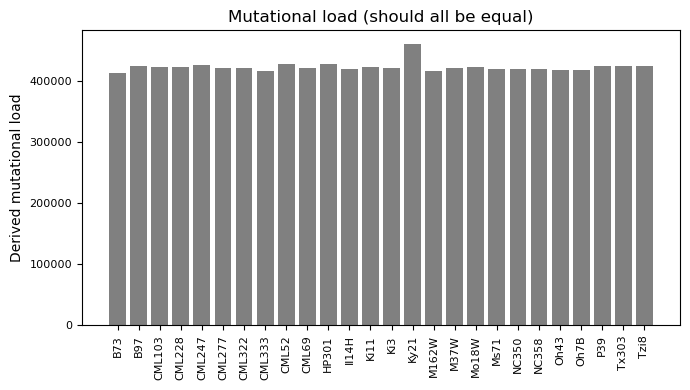

In [6]:
tsmut = new_ts_list[0]

sample_names=[]
for individual in tsmut.individuals():
    sam_name=individual.metadata['id']
    sample_names.append(sam_name.replace("_anchorwave", ""))
load=mutational_load(tsmut,windows=None)

plt.figure(figsize=(7, 4))
plt.bar(sample_names, load, color='grey')
plt.ylabel("Derived mutational load")
plt.title("Mutational load (should all be equal)")
plt.xticks(sample_names, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

This code removes one indvidiaul (in this case Ky21) and reruns the load check to show things look OK. Can skip unless you need to remove an individual, in which case **modify** for your names -- note the different behavior of individuals vs samples for diploids.

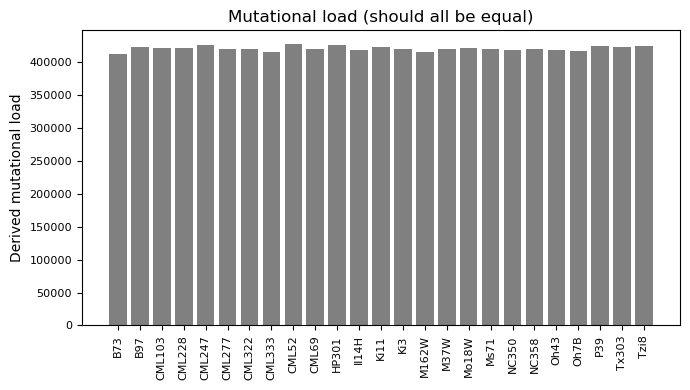

In [7]:

# Find individual ID with name Ky21
tsmut=new_ts_list[0]
ind_to_drop = None
for ind_id, ind in enumerate(tsmut.individuals()):
    if ind.metadata['id'].replace("_anchorwave", "") == "Ky21":
        ind_to_drop = ind_id
        break

if ind_to_drop is None:
    raise ValueError("Ky21 not found")

# Get the sample nodes belonging to that individual
drop_nodes = set(tsmut.individual(ind_to_drop).nodes)

# Keep all other sample nodes
keep = [u for u in tsmut.samples() if u not in drop_nodes]

# Simplify AND ASSIGN
tsmut = tsmut.simplify(samples=keep, keep_unary=True)

# Now lengths will match
load = mutational_load(tsmut, windows=None)

sample_names = []
for u in tsmut.samples():
    ind_id = tsmut.node(u).individual
    if ind_id != tskit.NULL:
        ind = tsmut.individual(ind_id)
        nm = ind.metadata["id"]
        nm = nm.replace("_anchorwave", "")
    else:
        nm = f"node{u}"
    sample_names.append(nm)

assert len(sample_names) == tsmut.num_samples  

plt.figure(figsize=(7, 4))
plt.bar(sample_names, load, color='grey')
plt.ylabel("Derived mutational load")
plt.title("Mutational load (should all be equal)")
plt.xticks(sample_names, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

In [8]:
target = "Ky21"
for i in range(len(new_ts_list)):
    print(i)
    new_ts_list[i] = drop_individual_by_name_fast(new_ts_list[i], "Ky21")
    gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


## Step 2 Sanity checks
First let's just look at π and Tajima's D along the chromosome to see if it looks OK. Will need to **modify** window size for your purposes.

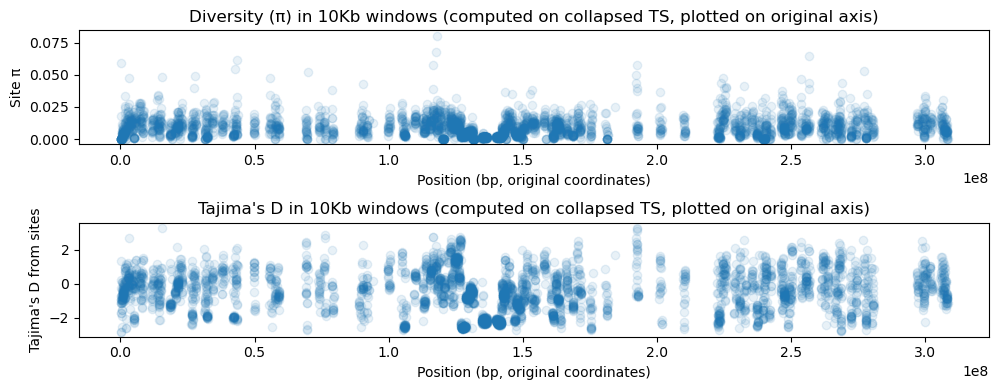

In [9]:
# Note that site_pi and mask and removed bp and length are same across all trees, so we just do this once.
# need old sequence length first. 
old_seq_length = None
old_ts = tszip.load(filtered_files[0])  
L = float(old_ts.sequence_length)
collapsed_winsize=100_000

# Choose windows in COLLAPSED coordinates
win_size = 10_000
ts3=new_ts_list[0]
L2 = float(ts3.sequence_length)
win2 = np.arange(0, L2 + win_size, win_size, dtype=float)
if win2[-1] > L2:
    win2[-1] = L2

pi2 = ts3.diversity(mode="site", windows=win2)  # per bp in collapsed coords
tajd2 = ts3.Tajimas_D(mode="site", windows=win2)  # per bp in collapsed coords

mid2 = 0.5 * (win2[:-1] + win2[1:])             # midpoints in collapsed coords

# Build inverse map and convert midpoints to ORIGINAL coordinates
new_grid, old_grid = inverse_cum_mass_map(mask, L, step=win_size)
mid_old = np.interp(mid2, new_grid, old_grid)   # approximate inverse

# Plot pi vs original coordinate midpoints
fig, axs = plt.subplots(2, 1, figsize=(10, 4)) # 1 row, 2 columns

axs[0].scatter(mid_old, pi2, alpha=0.1)
axs[0].set_xlabel("Position (bp, original coordinates)")
axs[0].set_ylabel("Site π")
axs[0].set_title(f"Diversity (π) in {int(win_size/1000)}Kb windows (computed on collapsed TS, plotted on original axis)")
axs[1].scatter(mid_old, tajd2, alpha=0.1)
axs[1].set_xlabel("Position (bp, original coordinates)")
axs[1].set_ylabel("Tajima's D from sites")
axs[1].set_title(f"Tajima's D in {int(win_size/1000)}Kb windows (computed on collapsed TS, plotted on original axis)")
plt.tight_layout()
plt.show()

Does the ARG fit the data? These two SFS should be extremely similar. If not, there's a problem and you should not continue.

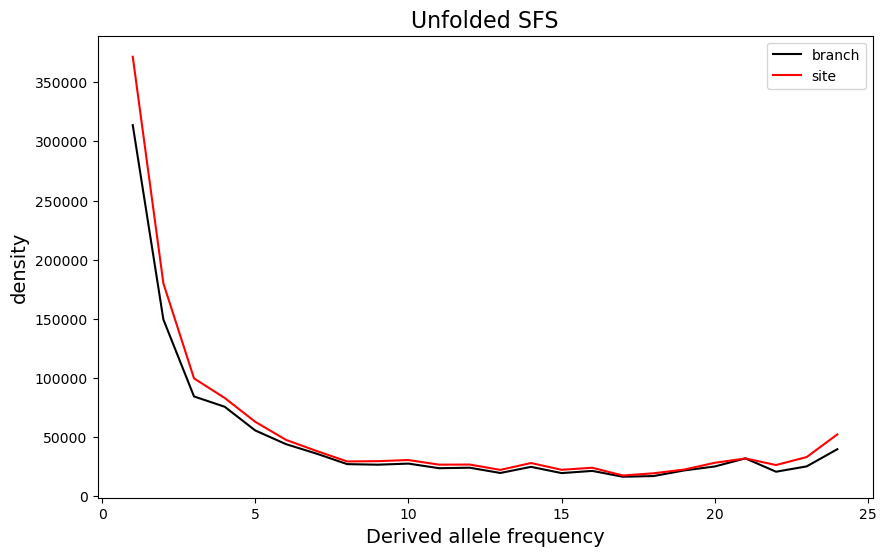

In [10]:
plt.figure(figsize=(10, 6))

obs_sfs=ts3.allele_frequency_spectrum(
        polarised=True,          # unfolded (requires polarization)
        mode="site",
        span_normalise=False     #  per-bp
    )

ts_sfs = ts3.allele_frequency_spectrum(
        polarised=True,          # unfolded (requires polarization)
        mode="branch",
        span_normalise=True     #  per-bp
    )
x=range(1,len(ts_sfs[1:-1])+1)

plt.plot(x,ts_sfs[1:-1],color="black",label="branch")
plt.plot(x,obs_sfs[1:-1],color="red",label="site")

plt.xlabel("Derived allele frequency",fontsize=14)
plt.ylabel("density",fontsize=14)
plt.title(f"Unfolded SFS",fontsize=16)
plt.legend()
plt.show()

## Step 3 Estimate Ne
First get coalescence rates, write to file. **modify** time bins to match your choice. For most cases, use every 100 years until 1000 years, then every 1,000 years tunil 10,000 then every 10,000 until 100,000. Note these are in years, so if your species generation time is not 1 per year, adjust these accordingly (e.g. for a species with a generation time of 2 years, divide everything by two). Stopping at 100K should be appropriate, because there are fewer coalescences farther back and we don't care about hitory beyond 100K for the most part. 

In [11]:
# time bins as desired are in time_bins.txt, but ARG was run with 3.3E-8 and we want to use 7.3E-8 
# adjusted time bins will give us back original time bins after mut rate correction downstream in R
time_bin_file="/home/jri/projects/contact/sandbox/new_rfb/time_bins.adjusted.txt" 
with open(time_bin_file, 'r') as f:
    ages = [int(line.strip()) for line in f if line.strip()]
time_chunks = np.concatenate(([0], ages, [np.inf]))

output = "collapsed_ts.coalrates.csv"
df_rates = compute_coalescence_rates(new_ts_list,time_chunks=time_chunks)
df_rates.to_csv(output, index=False)

Plot Ne trajectory from coalescent rates. **Modify** `axvline` times as appropriate for your system, and file names. Writes the mean trajectory to a demes format yaml, and checks by plotting from yaml.

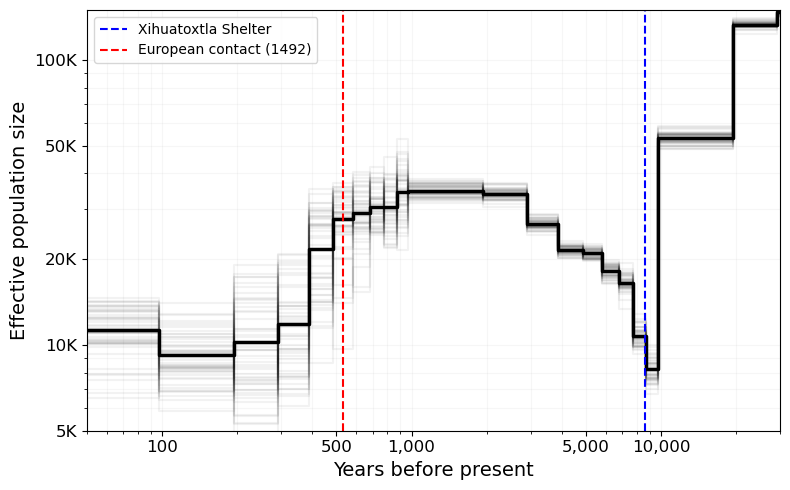

In [12]:
# Load rates
x = pd.read_csv("collapsed_ts.coalrates.csv")

# R: mutate(ne = 1/(2*rate), gen = gen*3.2/7.3)
x["ne"] = 1.0 / (2.0 * x["rate"])
x["gen"] = x["gen"] * 3.2 / 7.3 # modifying to use new mutation rates

ymean = (
    x.groupby("gen", as_index=False)
     .agg(ne_mean=("ne", "mean"))
)
#print(ymean.head(50))

fig, ax = plt.subplots(figsize=(8, 5))

# Replicate trajectories (faint)
for f, df in x.groupby("tree_number"):
    ax.step(df["gen"], df["ne"], where="post", alpha=0.05, color="black")

# Mean trajectory (bold)
ax.step(
    ymean["gen"],
    ymean["ne_mean"],
    where="post",
    color="black",
    linewidth=2.5,
)

# Log scales
ax.set_xscale("log")
ax.set_yscale("log")

# Labels
ax.set_xlabel("Years before present", fontsize=14)
ax.set_ylabel("Effective population size", fontsize=14)

# Limits
ax.set_xlim(50, 30000)
ax.set_ylim(5000, 150000)

# Vertical reference lines
ax.grid(which="both",alpha=0.1)
ax.tick_params(labelsize=12)
ax.axvline(8600, color="blue", linestyle="--", linewidth=1.5,label="Xihuatoxtla Shelter")
ax.axvline(533, color="red", linestyle="--", linewidth=1.5,label="European contact (1492)")

ax.set_yticks([5000,10000,20000,50000,100000], labels=['5K','10K','20K','50K','100K'])
ax.set_xticks([100,500,1000,5000,10000], labels=['100','500','1,000','5,000','10,000'])
plt.legend()
plt.tight_layout()
plt.show()
ax.axvline(533, color="red", linestyle="--", linewidth=1.5)

write_demes_from_ymean(
    ymean,
    outfile="mean_ne_from_coalescence.demes.yaml",
    deme_name="collapsed_pop",
)

Load demes, check model

<Axes: xlabel='time ago (years)', ylabel='deme\nsize'>

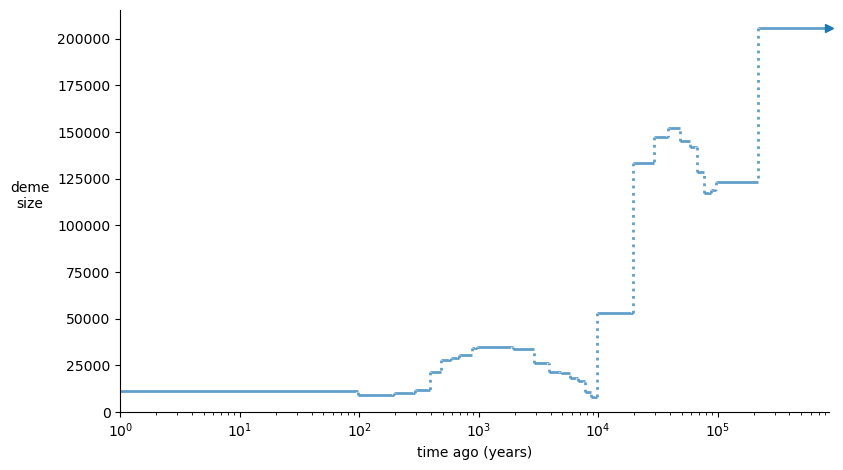

In [13]:
demes_file = "mean_ne_from_coalescence.demes.yaml"

graph = demes.load(demes_file)
#Sanity check (optional but useful):
#print(graph)

demesdraw.size_history(graph, log_time=True)

## Step 4 Validate model
Let's simualte data under the model to see if it can generate observed patterns. **Modify** window size, mutation rate, sample size, recombination rate, and number of sims as appropriate. Recommended larger windows (100kb or bigger).

In [14]:
demography = msprime.Demography.from_demes(graph)

nsims = 1000
window_length = 100_000
sample_size = 25          #  haplotypes
recomb_rate = 1e-8        # per bp per generation
mut_rate = 7.3e-8         # use your corrected mutation rate

ts_list = []
ts_pi = []
ts_d = []
ts_sfs = []

for i in range(nsims):
    ts = msprime.sim_ancestry(
        samples=sample_size,
        demography=demography,
        sequence_length=window_length,
        recombination_rate=recomb_rate,
        ploidy=1,
    )

    ts = msprime.sim_mutations(ts, rate=mut_rate)
    ts_pi.append(ts.diversity(mode="site"))
    ts_d.append(ts.Tajimas_D(mode="site"))
    ts_list.append(ts)
    ts_sfs.append(ts.allele_frequency_spectrum(polarised=True, span_normalise=True))

ts3=new_ts_list[0]
obs_pi=ts3.diversity(mode="site")
obs_d=ts3.Tajimas_D(mode="site")
obs_sfs=ts3.allele_frequency_spectrum(
        polarised=True,          # unfolded (requires polarization)
        mode="site",
        span_normalise=True     #  per-bp
    )
print(f"Simulated {len(ts_list)} independent {window_length} kb windows")

Simulated 1000 independent 100000 kb windows


Check stats: first π

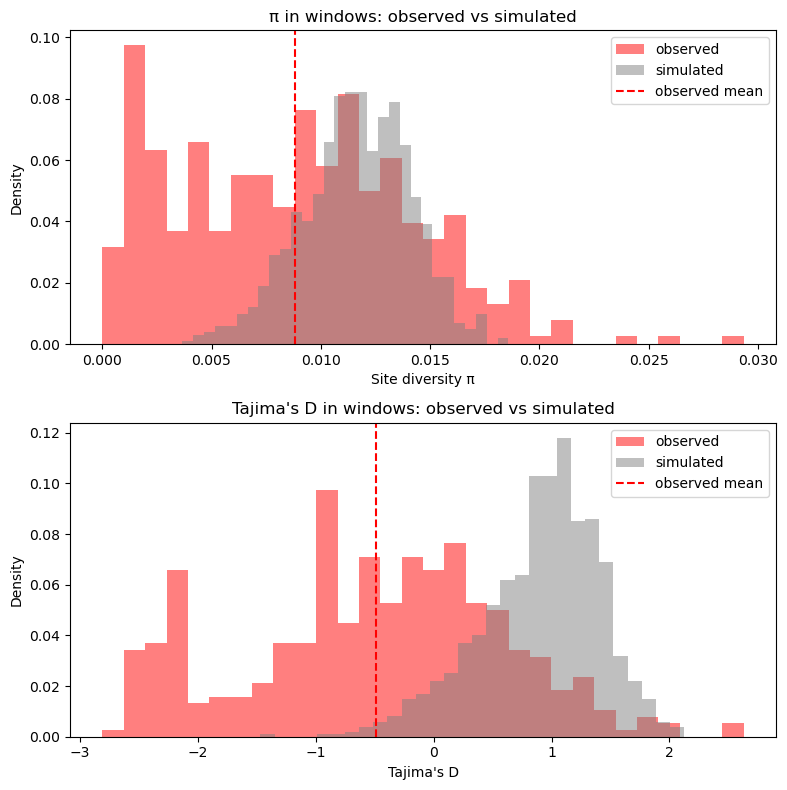

In [15]:
# --- window setup ---
L2 = float(ts3.sequence_length)
win2 = np.arange(0, L2 + window_length, window_length, dtype=float)
if win2[-1] > L2:
    win2[-1] = L2

# =========================
# Observed statistics
# =========================
obs_pi = ts3.diversity(mode="site", windows=win2)
obs_pi = pd.DataFrame({"pi": obs_pi})

obs_td = ts3.Tajimas_D(mode="site", windows=win2)
obs_td = pd.DataFrame({"tajd": obs_td}).dropna()   # Tajima's D needs NaN handling

# normalize histograms
weights_obs_pi = np.ones(len(obs_pi)) / len(obs_pi)
weights_obs_td = np.ones(len(obs_td)) / len(obs_td)

# =========================
# Simulated statistics
# =========================
# ts_pi: 1D array of simulated π values
# ts_tajd: 1D array of simulated Tajima's D values
sim_pi = pd.DataFrame({"pi": ts_pi})
sim_td = pd.DataFrame({"tajd": ts_d}).dropna()

weights_sim_pi = np.ones(len(sim_pi)) / len(sim_pi)
weights_sim_td = np.ones(len(sim_td)) / len(sim_td)

# =========================
# Plot
# =========================
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# ---- π histogram ----
axs[0].hist(
    obs_pi["pi"],
    bins=30,
    weights=weights_obs_pi,
    alpha=0.5,
    color="red",
    label="observed",
)

axs[0].hist(
    sim_pi["pi"],
    bins=30,
    weights=weights_sim_pi,
    alpha=0.5,
    color="grey",
    label="simulated",
)

axs[0].axvline(
    obs_pi["pi"].mean(),
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="observed mean",
)

axs[0].set_xlabel("Site diversity π")
axs[0].set_ylabel("Density")
axs[0].set_title("π in windows: observed vs simulated")
axs[0].legend()

# ---- Tajima's D histogram ----
axs[1].hist(
    obs_td["tajd"],
    bins=30,
    weights=weights_obs_td,
    alpha=0.5,
    color="red",
    label="observed",
)

axs[1].hist(
    sim_td["tajd"],
    bins=30,
    weights=weights_sim_td,
    alpha=0.5,
    color="grey",
    label="simulated",
)

axs[1].axvline(
    obs_td["tajd"].mean(),
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="observed mean",
)

axs[1].set_xlabel("Tajima's D")
axs[1].set_ylabel("Density")
axs[1].set_title("Tajima's D in windows: observed vs simulated")
axs[1].legend()

plt.tight_layout()
plt.show()

Now plot jointly.

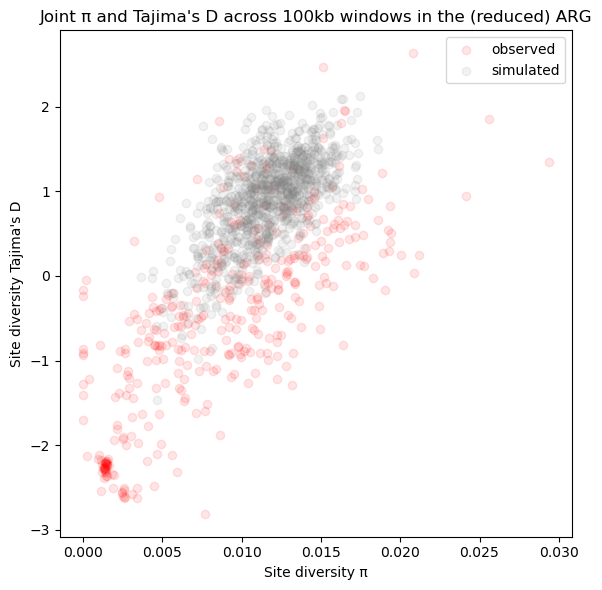

In [17]:
L2 = float(ts3.sequence_length)
win2 = np.arange(0, L2 + window_length, window_length, dtype=float)
if win2[-1] > L2:
    win2[-1] = L2

obs_pi = ts3.diversity(mode="site", windows=win2)
obs_d = ts3.Tajimas_D(mode="site", windows=win2)

plt.figure(figsize=(6,6))

plt.scatter(x=obs_pi,y=obs_d,color="red", alpha=0.1, label="observed")
plt.scatter(x=ts_pi,y=ts_d,color="grey", alpha=0.1, label="simulated")

plt.ylabel("Site diversity Tajima's D")
plt.xlabel("Site diversity π")

plt.title(f"Joint π and Tajima's D across {int(window_length/1000)}kb windows in the (reduced) ARG")
plt.legend()
plt.tight_layout()
plt.show()


Check SFS

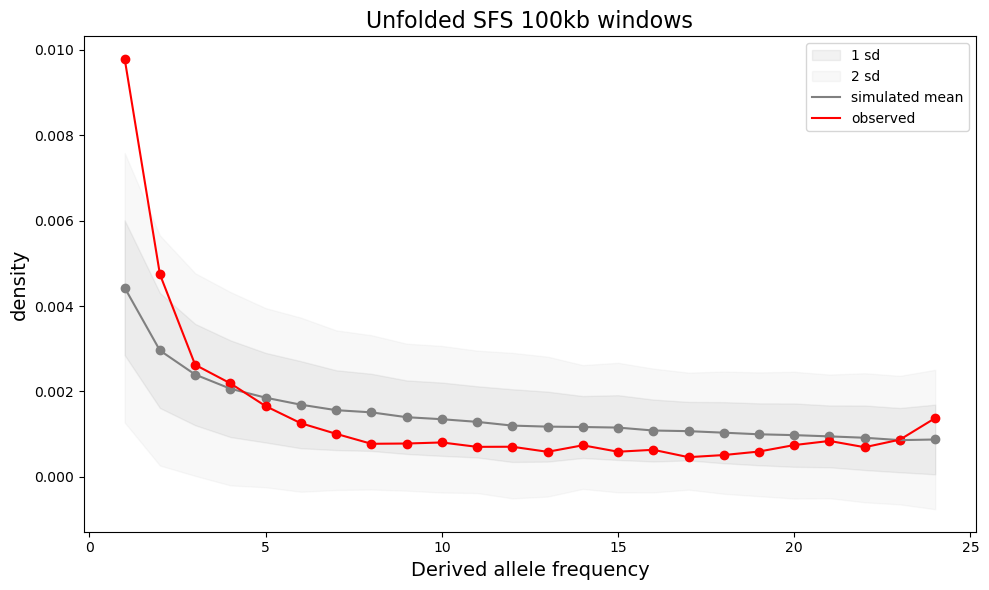

In [18]:
plt.figure(figsize=(10, 6))

ts_sfs = np.array(ts_sfs)
mean_sfs=ts_sfs.mean(axis = 0)
sd_sfs=ts_sfs.std(axis = 0)
x=range(1,len(mean_sfs[1:-1])+1)

plt.scatter(x,mean_sfs[1:-1],color="grey")
plt.fill_between(x, mean_sfs[1:-1] - sd_sfs[1:-1], mean_sfs[1:-1] + sd_sfs[1:-1], color="grey", alpha=0.1,label="1 sd")
plt.fill_between(x, mean_sfs[1:-1] - 2*sd_sfs[1:-1], mean_sfs[1:-1] + 2*sd_sfs[1:-1], color="grey", alpha=0.05,label="2 sd")
plt.plot(x,mean_sfs[1:-1],color="grey",label="simulated mean")

plt.scatter(x,obs_sfs[1:-1],color="red")
plt.plot(x,obs_sfs[1:-1],color="red",label="observed")

plt.xlabel("Derived allele frequency",fontsize=14)
plt.ylabel("density",fontsize=14)
plt.title(f"Unfolded SFS {int(window_length/1000)}kb windows",fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()